In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

# ==============================
# AdaptiveKDE Class
# ==============================
class AdaptiveKDE:
    def __init__(self, data, base_bandwidth=1.0, k=3):
        self.data = data
        self.k = k
        self.base_bandwidth = base_bandwidth
        self.kdes = []
        self._fit_adaptive_kde()

    def _fit_adaptive_kde(self):
        distances = pairwise_distances(self.data)
        for i in range(self.data.shape[0]):
            local_bandwidth = self.base_bandwidth * np.mean(np.sort(distances[i])[:self.k])
            kde = KernelDensity(kernel='gaussian', bandwidth=local_bandwidth)
            kde.fit(self.data)
            self.kdes.append(kde)

    def log_prob(self, samples):
        log_probs = np.zeros(samples.shape[0])
        for kde in self.kdes:
            log_probs += kde.score_samples(samples)
        return log_probs / len(self.kdes)

# ==============================
# Initialiser and Enhancer
# ==============================
class Initialiser(nn.Module):
    def __init__(self, input_dim):
        super(Initialiser, self).__init__()
        layers = []
        for _ in range(10 * input_dim):  # Dynamically create layers
            layers.append(nn.Linear(input_dim, input_dim))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class Enhancer(nn.Module):
    def __init__(self, input_dim):
        super(Enhancer, self).__init__()
        layers = []
        for _ in range(20 * input_dim):  # Dynamically create layers
            layers.append(nn.Linear(input_dim, input_dim))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)


# ==============================
# AIENs Model
# ==============================
class AIENs(nn.Module):
    def __init__(self, input_dim):
        super(AIENs, self).__init__()
        self.initialiser = Initialiser(input_dim)
        self.fc_mu = nn.Linear(input_dim, input_dim)
        self.fc_logvar = nn.Linear(input_dim, input_dim)
        self.enhancer = Enhancer(input_dim)

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent = self.initialiser(x)
        mu, logvar = self.fc_mu(latent), self.fc_logvar(latent)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.enhancer(z)
        return reconstruction, mu, logvar

# ==============================
# Data Loading and Saving
# ==============================
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    numeric_data = data.iloc[:, :-6].values  # Assume 10 dimensions
    return numeric_data

def save_synthetic_data(synthetic_data, output_file):
    columns = ['Feature_' + str(i+1) for i in range(synthetic_data.shape[1])]
    synthetic_df = pd.DataFrame(np.round(synthetic_data, 4), columns=columns)
    synthetic_df['Class'] = "SEKER"
    synthetic_df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")

# ==============================
# Training Function
# ==============================
def train_aien(model, dataloader, adaptive_kde, optimizer, num_epochs=50, beta=1.0):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            x = batch.float()
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            mse_loss = F.mse_loss(recon_x, x, reduction='sum')
            kl_div = torch.sum(torch.tensor(adaptive_kde.log_prob(z.cpu().detach().numpy())))
            loss = mse_loss + beta * kl_div
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.2f}")
    return epoch_losses

# ==============================
# Visualization
# ==============================
def plot_loss(epoch_losses):
    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
# Synthetic Data Generation only on enhancer
def generate_synthetic_data(model, no_of_sample, input_dim):
    model.eval()
    with torch.no_grad():
        # Sample latent space
        z = torch.randn(no_of_sample, input_dim)
        # Generate synthetic data
        synthetic_data = model.enhancer(z).numpy()
    return synthetic_data

def generate_synthetic_data_full_aien(model, no_of_sample, input_dim):
    """
    Generate synthetic data using the full AIENs model.

    Parameters:
    - model: Trained AIENs model.
    - no_of_sample: Number of synthetic samples to generate.
    - input_dim: Number of features in the dataset.

    Returns:
    - synthetic_data: NumPy array of generated synthetic data.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Step 1: Sample latent space from standard Gaussian
        z = torch.randn(no_of_sample, input_dim)
        
        # Step 2: Pass through Initialiser to simulate latent space
        latent = model.initialiser(z)
        
        # Step 3: Compute mu and logvar from Initialiser output
        mu, logvar = model.fc_mu(latent), model.fc_logvar(latent)
        
        # Step 4: Reparameterize latent space
        z_reparameterized = model.reparameterize(mu, logvar)
        
        # Step 5: Pass through Enhancer to generate synthetic data
        synthetic_data = model.enhancer(z_reparameterized).cpu().numpy()
    
    return synthetic_data

In [2]:
import torch
import torch.nn.functional as F

def train_aien_and_save_best_model(model, dataloader, adaptive_kde, optimizer, num_epochs=50, beta=1.0, save_path="best_model.pth"):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    model.train()
    epoch_losses = []
    best_loss = float('inf')  # Initialize with infinity

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            x = batch.float()
            optimizer.zero_grad()
            
            # Forward pass
            recon_x, mu, logvar = model(x)
            z = model.reparameterize(mu, logvar)
            
            # Compute losses
            mse_loss = F.mse_loss(recon_x, x, reduction='sum')
            kl_div = torch.sum(torch.tensor(adaptive_kde.log_prob(z.cpu().detach().numpy())))
            loss = mse_loss + beta * kl_div
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Learning rate scheduler step
        scheduler.step()
        
        # Log loss for the current epoch
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.2f}")

        # Save the model if this is the best loss so far
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved with loss: {best_loss:.2f}")

    return epoch_losses


Model Summary:
Epoch 1/500, Loss: 99615068963.56
New best model saved with loss: 99615068963.56
Epoch 2/500, Loss: 99615060804.68
New best model saved with loss: 99615060804.68
Epoch 3/500, Loss: 99615044434.18
New best model saved with loss: 99615044434.18
Epoch 4/500, Loss: 99615036237.02
New best model saved with loss: 99615036237.02
Epoch 5/500, Loss: 99615019806.94
New best model saved with loss: 99615019806.94
Epoch 6/500, Loss: 99615019847.35
Epoch 7/500, Loss: 99615003467.18
New best model saved with loss: 99615003467.18
Epoch 8/500, Loss: 99614987096.99
New best model saved with loss: 99614987096.99
Epoch 9/500, Loss: 99614978898.98
New best model saved with loss: 99614978898.98
Epoch 10/500, Loss: 99614954300.34
New best model saved with loss: 99614954300.34
Epoch 11/500, Loss: 99614954295.82
New best model saved with loss: 99614954295.82
Epoch 12/500, Loss: 99614946120.08
New best model saved with loss: 99614946120.08
Epoch 13/500, Loss: 99614937919.66
New best model saved w

Epoch 104/500, Loss: 99613102893.83
New best model saved with loss: 99613102893.83
Epoch 105/500, Loss: 99613045523.90
New best model saved with loss: 99613045523.90
Epoch 106/500, Loss: 99612980036.87
New best model saved with loss: 99612980036.87
Epoch 107/500, Loss: 99612906264.83
New best model saved with loss: 99612906264.83
Epoch 108/500, Loss: 99612857131.64
New best model saved with loss: 99612857131.64
Epoch 109/500, Loss: 99612775221.85
New best model saved with loss: 99612775221.85
Epoch 110/500, Loss: 99612709718.46
New best model saved with loss: 99612709718.46
Epoch 111/500, Loss: 99612644166.49
New best model saved with loss: 99612644166.49
Epoch 112/500, Loss: 99612545842.40
New best model saved with loss: 99612545842.40
Epoch 113/500, Loss: 99612472104.21
New best model saved with loss: 99612472104.21
Epoch 114/500, Loss: 99612365616.38
New best model saved with loss: 99612365616.38
Epoch 115/500, Loss: 99612275501.52
New best model saved with loss: 99612275501.52
Epoc

Epoch 203/500, Loss: 99332887377.42
New best model saved with loss: 99332887377.42
Epoch 204/500, Loss: 99323769667.41
New best model saved with loss: 99323769667.41
Epoch 205/500, Loss: 99314365240.82
New best model saved with loss: 99314365240.82
Epoch 206/500, Loss: 99304674095.71
New best model saved with loss: 99304674095.71
Epoch 207/500, Loss: 99294712649.51
New best model saved with loss: 99294712649.51
Epoch 208/500, Loss: 99284448031.82
New best model saved with loss: 99284448031.82
Epoch 209/500, Loss: 99273888570.83
New best model saved with loss: 99273888570.83
Epoch 210/500, Loss: 99263017776.31
New best model saved with loss: 99263017776.31
Epoch 211/500, Loss: 99251852068.75
New best model saved with loss: 99251852068.75
Epoch 212/500, Loss: 99240366930.03
New best model saved with loss: 99240366930.03
Epoch 213/500, Loss: 99228554008.07
New best model saved with loss: 99228554008.07
Epoch 214/500, Loss: 99216421704.87
New best model saved with loss: 99216421704.87
Epoc

Epoch 303/500, Loss: 94536053519.81
New best model saved with loss: 94536053519.81
Epoch 304/500, Loss: 94464561967.82
New best model saved with loss: 94464561967.82
Epoch 305/500, Loss: 94392210258.80
New best model saved with loss: 94392210258.80
Epoch 306/500, Loss: 94319072038.32
New best model saved with loss: 94319072038.32
Epoch 307/500, Loss: 94245139219.53
New best model saved with loss: 94245139219.53
Epoch 308/500, Loss: 94170452800.90
New best model saved with loss: 94170452800.90
Epoch 309/500, Loss: 94095029045.64
New best model saved with loss: 94095029045.64
Epoch 310/500, Loss: 94018868013.03
New best model saved with loss: 94018868013.03
Epoch 311/500, Loss: 93941986126.66
New best model saved with loss: 93941986126.66
Epoch 312/500, Loss: 93864391493.84
New best model saved with loss: 93864391493.84
Epoch 313/500, Loss: 93786092363.04
New best model saved with loss: 93786092363.04
Epoch 314/500, Loss: 93707088682.21
New best model saved with loss: 93707088682.21
Epoc

Epoch 403/500, Loss: 83171144503.32
New best model saved with loss: 83171144503.32
Epoch 404/500, Loss: 83084817199.12
New best model saved with loss: 83084817199.12
Epoch 405/500, Loss: 82998211396.57
New best model saved with loss: 82998211396.57
Epoch 406/500, Loss: 82911376173.97
New best model saved with loss: 82911376173.97
Epoch 407/500, Loss: 82824295234.71
New best model saved with loss: 82824295234.71
Epoch 408/500, Loss: 82737001271.78
New best model saved with loss: 82737001271.78
Epoch 409/500, Loss: 82649527122.08
New best model saved with loss: 82649527122.08
Epoch 410/500, Loss: 82561856320.44
New best model saved with loss: 82561856320.44
Epoch 411/500, Loss: 82474029854.62
New best model saved with loss: 82474029854.62
Epoch 412/500, Loss: 82386023216.44
New best model saved with loss: 82386023216.44
Epoch 413/500, Loss: 82297852748.40
New best model saved with loss: 82297852748.40
Epoch 414/500, Loss: 82209551126.69
New best model saved with loss: 82209551126.69
Epoc

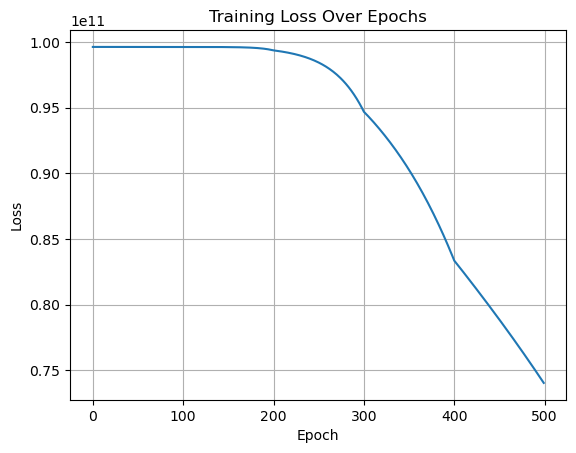

Synthetic data saved to synthetic_data_1.csv


In [5]:
model = None
if __name__ == "__main__":
    input_file = "bean1.csv"
    dataset = load_data(input_file)
    adaptive_kde = AdaptiveKDE(dataset)
    
    input_dim = 11
    model = AIENs(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    dataloader = torch.utils.data.DataLoader(
        torch.from_numpy(dataset).float(), batch_size=50, shuffle=True
    )

    print("Model Summary:")
    summary(model, input_size=(50, input_dim))

    # Train and save the best model
    epoch_losses = train_aien_and_save_best_model(model, dataloader, adaptive_kde, optimizer, num_epochs=500, save_path="best_model.pth")

    # Plot training loss
    plot_loss(epoch_losses)

    # Load the best model for generating synthetic data
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    # Generate and Save Synthetic Data
#     synthetic_data = generate_synthetic_data_full_aien(model, 500, input_dim)
    synthetic_data = generate_synthetic_data(model, 500, input_dim)

    save_synthetic_data(synthetic_data, "synthetic_data_1.csv")


In [6]:
from torchinfo import summary

# Assuming `model` is your AIENs model and `input_dim` is defined
print("Model Summary:")
summary(model, input_size=(50, input_dim))  # 32 represents batch size


Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
AIENs                                    [50, 11]                  --
├─Initialiser: 1-1                       [50, 11]                  --
│    └─Sequential: 2-1                   [50, 11]                  --
│    │    └─Linear: 3-1                  [50, 11]                  132
│    │    └─ReLU: 3-2                    [50, 11]                  --
│    │    └─Linear: 3-3                  [50, 11]                  132
│    │    └─ReLU: 3-4                    [50, 11]                  --
│    │    └─Linear: 3-5                  [50, 11]                  132
│    │    └─ReLU: 3-6                    [50, 11]                  --
│    │    └─Linear: 3-7                  [50, 11]                  132
│    │    └─ReLU: 3-8                    [50, 11]                  --
│    │    └─Linear: 3-9                  [50, 11]                  132
│    │    └─ReLU: 3-10                   [50, 11]                  --
│    │    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# AdaptiveKDE Class (as previously defined)
class AdaptiveKDE:
    def __init__(self, data, base_bandwidth=1, k=3):
        self.data = data
        self.k = k
        self.base_bandwidth = base_bandwidth
        self.kdes = []
        self._fit_adaptive_kde()

    def _fit_adaptive_kde(self):
        distances = pairwise_distances(self.data)
        for i in range(self.data.shape[0]):
            local_bandwidth = self.base_bandwidth * np.mean(np.sort(distances[i])[:self.k])
            kde = KernelDensity(kernel='gaussian', bandwidth=local_bandwidth)
            kde.fit(self.data)
            self.kdes.append(kde)

    def sample(self, n_samples):
        samples = []
        for _ in range(n_samples):
            # Randomly choose one of the KDEs and sample from it
            chosen_kde = np.random.choice(self.kdes)
            sample = chosen_kde.sample(1)[0]  # Sample one point
            samples.append(sample)
        return np.array(samples)

    def plot_distribution(self, original_data, synthetic_data):
        plt.figure(figsize=(10, 6))
        plt.scatter(original_data[:, 0], original_data[:, 1], color='blue', label='Original Data', alpha=0.5)
        plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], color='red', label='Synthetic Data', alpha=0.5)
        plt.title('Original vs Synthetic Data (First Two Dimensions)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Load Data
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    numeric_data = data.iloc[:, :-6].values  # Exclude class label
    return numeric_data

# Save Synthetic Data
def save_synthetic_data_kde(synthetic_data, output_file):
    columns = ['Feature_' + str(i+1) for i in range(synthetic_data.shape[1] - 1)] + ['Class']
    synthetic_df = pd.DataFrame(np.round(synthetic_data, 4), columns=columns)
    synthetic_df['Class'] = "KDE_Synthetic"
    synthetic_df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")

# Main Script for Adaptive KDE
if __name__ == "__main__":
    input_file = "bean1.csv"
    dataset = load_data(input_file)

    # Fit Adaptive KDE
    adaptive_kde = AdaptiveKDE(dataset)

    # Generate synthetic data from KDE
    synthetic_data_kde = adaptive_kde.sample(500)  # Generate 500 synthetic samples

    # Plot original vs synthetic
    adaptive_kde.plot_distribution(dataset, synthetic_data_kde)

    # Save synthetic data
    save_synthetic_data_kde(synthetic_data_kde, "synthetic_data_kde.csv")
